#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('//datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


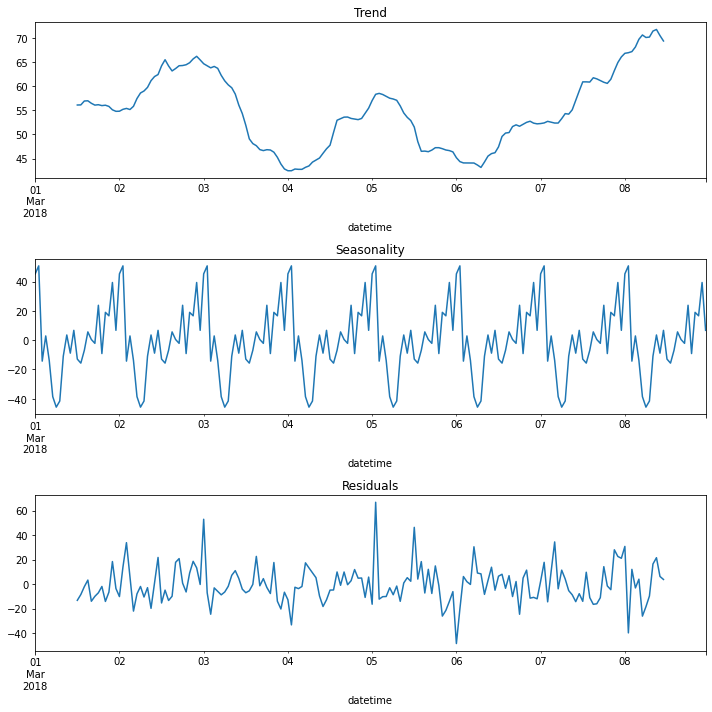

In [4]:

data_1 = data['2018-03-01':'2018-03-08']

decomposed = seasonal_decompose(data_1) 

plt.figure(figsize=(10, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Из графиков можно сделать вывод, что вечером и ночью заказов в разы больше, чем утром и днем.

## Анализ

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [6]:
make_features(data, 30,40)
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0,164.150
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,162.725
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,161.925


## Обучение

In [7]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [8]:
#LinearRegression
model = LinearRegression()
model.fit(features_train,target_train)
train_pred = model.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train,train_pred)**0.5)


RMSE обучающей выборки: 25.162063268252812


In [9]:
#RandomForestRegressor
model = RandomForestRegressor(n_estimators=50,max_depth=10,random_state=12345)
model.fit(features_train,target_train)
train_pred = model.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train,train_pred)**0.5)

RMSE обучающей выборки: 14.446462398054189


In [18]:
best_depth_light = 0
best_result_light = -1000000000000000000000000000

for depth in range(1, 20, 1):
    model = RandomForestRegressor(n_estimators=50,max_depth=depth,random_state=12345)
    cv = TimeSeriesSplit(n_splits=3, test_size=2)

    
    scores = cross_val_score(model,features_train, target_train, cv=cv,scoring= 'neg_root_mean_squared_error')
    if scores.mean() > best_result_light:
        best_depth_light = depth
        
        best_result_light = scores.mean()
            
print(best_depth_light,best_result_light)

12 -25.975709503775494


## Тестирование

In [11]:
%%time
model = LinearRegression()
model.fit(features_train,target_train)

CPU times: user 32.8 ms, sys: 32.3 ms, total: 65 ms
Wall time: 22.4 ms


LinearRegression()

In [12]:
%%time
test_pred = model.predict(features_test)

CPU times: user 17.9 ms, sys: 35.6 ms, total: 53.6 ms
Wall time: 90.3 ms


In [13]:

print("RMSEтестовой выборки: ",mean_squared_error(target_test,test_pred)**0.5)

RMSEтестовой выборки:  48.754970308060244


In [19]:
%%time
model = RandomForestRegressor(n_estimators=50,max_depth=12,random_state=12345)
model.fit(features_train,target_train)

CPU times: user 2.49 s, sys: 11.8 ms, total: 2.5 s
Wall time: 2.52 s


RandomForestRegressor(max_depth=12, n_estimators=50, random_state=12345)

In [20]:
%%time
test_pred = model.predict(features_test)

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 10.1 ms


In [22]:

print("RMSEтестовой выборки: ",mean_squared_error(target_test,test_pred)**0.5)

RMSEтестовой выборки:  44.27575849281387


In [23]:
results = pd.DataFrame({'models' : ['LinearRegression', 'RandomForestRegressor'],
                        'fit_time' : ['22.1 ms', '2.52 s'],
                        'pred_time' : ['99.7 ms', '10.1 ms'],
                        'metrics' : [48.75, 44.27]})
results

,models,fit_time,pred_time,metrics
0,LinearRegression,22.1 ms,99.7 ms,48.75
1,RandomForestRegressor,2.52 s,10.1 ms,44.27


Модель RandomForest показала лучший результат RMSE, хотя время обучения заняло больше времени, чем LinearRegression, но важна точность в иследовании, поэтому лучшей моделью выбираем RandomForest